In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import cv2
from tqdm.notebook import trange, tqdm
import random
from tqdm.auto import tqdm

import time

import sys, os
BASE = os.getcwd()  
if BASE not in sys.path:
    sys.path.append(BASE)

from funcs import *          
from funcs import utils      
from funcs import proj_cam_model, NetParallelTrain

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
DEVICE = 'cuda'
setup_seed(48*4)
n_pts = 928
pattern_shape = 512


## Pattern

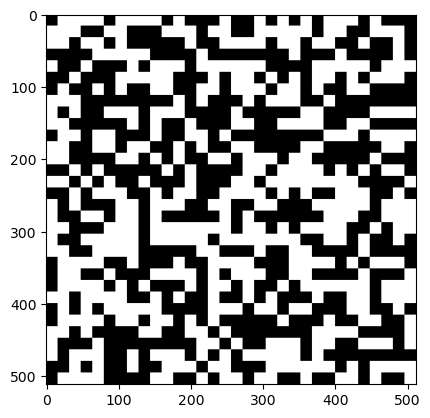

In [2]:
pattern = torch.from_numpy(cv2.cvtColor(cv2.imread('./Patterns/pattern_16.png'), cv2.COLOR_BGR2RGB))
pattern = pattern/pattern.max()
plt.imshow(pattern)
plt.show()
pattern = pattern.permute(2,0,1)
# 

## Compare with Blender (fx = fy)

Projector focal (fx, fy): (2482.4254976091, 2482.4254976091)
Projector principal point offset (Δx, Δy): (-7.937139974905222, 292.7977517663371)
Camera focal (fx, fy): (4518.294794463839, 4518.294794463839)
Camera principal point offset (Δx, Δy): (82.70724123378898, -37.649569100704184)


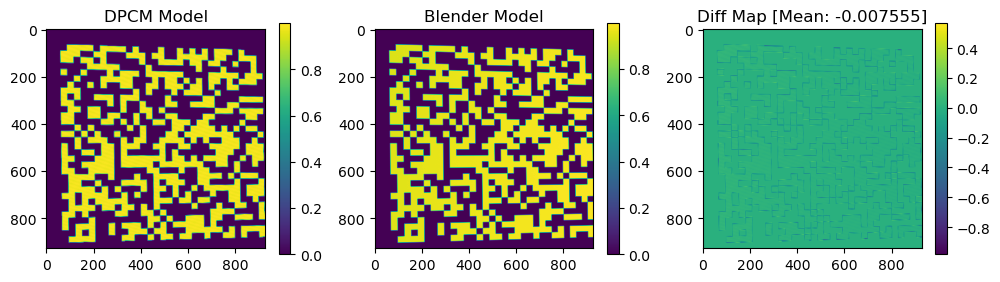

In [3]:
calib_results = utils.json_loader(file_path='./Calibration/Blender_compare_calibration_summary-fx=fy.json')

cam_COP = calib_results['camera_position_world']
cam_R = calib_results['R_world_to_camera']
cam_K = calib_results['camera_intrinsic']
proj_COP = calib_results['projector_position_world']
proj_R = calib_results['R_world_to_projector']
proj_K = calib_results['projector_intrinsic']
proj_t = -proj_R @ proj_COP
cam_t = -cam_R @ cam_COP


cam_res = (n_pts, n_pts)   
proj_res = (pattern_shape, pattern_shape)  

intrinsics_para = parse_intrinsics(cam_K, proj_K, cam_res, proj_res)

print("Projector focal (fx, fy):", intrinsics_para["projector"]["focal"])
print("Projector principal point offset (Δx, Δy):", intrinsics_para["projector"]["offset"])
print("Camera focal (fx, fy):", intrinsics_para["camera"]["focal"])
print("Camera principal point offset (Δx, Δy):", intrinsics_para["camera"]["offset"])


proj_sensor_size = min(proj_res)
proj_fx, proj_fy = intrinsics_para["projector"]["focal"]   # (fx, fy)
proj_f = np.mean(intrinsics_para["projector"]["focal"])
proj_cx_px, proj_cy_px = intrinsics_para["projector"]["offset"]

cam_sensor_size = min(cam_res)
cam_fx,  cam_fy  = intrinsics_para["camera"]["focal"]      # (fx, fy)
cam_f = np.mean(intrinsics_para["camera"]["focal"])      # (fx, fy)
cam_cx_px, cam_cy_px = intrinsics_para["camera"]["offset"]
     
    
extent_mm = [-100, 260, -260, 260]   


# Extent in mm
xmin, xmax, ymin, ymax = extent_mm

# Resolution
num = proj_res  # 

# Create meshgrid (PyTorch)
x = torch.linspace(xmin, xmax, num[0])
y = torch.linspace(ymin, ymax, num[1])

X, Y = torch.meshgrid(x, y, indexing="xy")  

# Compute Z(x,y)
height_map_whiteboard = torch.zeros((pattern_shape,pattern_shape))

# cam_resolution = 3036
cam_resolution = n_pts
num_photons = None

measured_img = torch.zeros((pattern.shape[0], n_pts, n_pts))[None,:,:,:].to(DEVICE)
reflectance = torch.ones_like(pattern)
for pattern_c in range(pattern.shape[0]):
    pattern_proj = pattern[pattern_c,:,:]
    imager2 = Proj_Cam_model(
#         proj_f, cam_f,
        proj_f=(proj_fx, proj_fy),
        cam_f=(cam_fx, cam_fy),

        proj_sensor_w_px=proj_sensor_size,
        proj_sensor_h_px=proj_sensor_size,
        cam_sensor_px=cam_sensor_size,

        proj_R=proj_R, proj_t=proj_t,
        cam_R=cam_R, cam_t=cam_t,

        proj_cx_px=proj_cx_px ,
        proj_cy_px=proj_cy_px ,
        cam_cx_px=cam_cx_px,
        cam_cy_px=cam_cy_px,

        device=DEVICE
    )
    measured_img2 = imager2.render(height_map_whiteboard, reflectance[pattern_c,:,:], pattern_proj,
                                   extent_mm=extent_mm,
                                   photon_count=num_photons, show=0, print_matrix= 0,
                                   cam_res=(cam_resolution, cam_resolution))
    measured_img[0,pattern_c,:,:] = measured_img2.squeeze()
measured_img_gray = cv2.cvtColor(np.array(measured_img.squeeze().permute(1,2,0).cpu()), cv2.COLOR_RGB2GRAY)

# imager2.plot_geometry(axis_length = 150)
blender_out = torch.tensor(cv2.cvtColor(cv2.imread('./Calibration/render_output_bw_fx=fy.tiff'), cv2.COLOR_BGR2RGB))
min_val = blender_out.amin(dim=(0,1), keepdim=True)
max_val = blender_out.amax(dim=(0,1), keepdim=True)

blender_out = (blender_out - min_val) / (max_val - min_val + 1e-8)
blender_out_gray = cv2.cvtColor(np.array(blender_out), cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (12,3))
plt.subplot(131)
plt.imshow(measured_img_gray)
plt.title('DPCM Model')
plt.colorbar()
plt.subplot(132)
plt.imshow(blender_out_gray)
plt.title('Blender Model')
plt.colorbar()
plt.subplot(133)
I_diff = measured_img_gray - blender_out_gray
plt.imshow(I_diff)
plt.title(f'Diff Map [Mean: {np.mean(I_diff):.6f}]')
plt.colorbar()
plt.show()

## Compare with Real Data (fx != fy)

In [4]:
calib_results = utils.json_loader(file_path='./Calibration/Blender_compare_calibration_summary.json')

cam_COP = calib_results['camera_position_world']
cam_R = calib_results['R_world_to_camera']
cam_K = calib_results['camera_intrinsic']
proj_COP = calib_results['projector_position_world']
proj_R = calib_results['R_world_to_projector']
proj_K = calib_results['projector_intrinsic']

In [5]:
proj_t = -proj_R @ proj_COP
cam_t = -cam_R @ cam_COP


cam_res = (n_pts, n_pts)   
proj_res = (pattern_shape, pattern_shape)  

intrinsics_para = parse_intrinsics(cam_K, proj_K, cam_res, proj_res)

print("Projector focal (fx, fy):", intrinsics_para["projector"]["focal"])
print("Projector principal point offset (Δx, Δy):", intrinsics_para["projector"]["offset"])
print("Camera focal (fx, fy):", intrinsics_para["camera"]["focal"])
print("Camera principal point offset (Δx, Δy):", intrinsics_para["camera"]["offset"])


proj_sensor_size = min(proj_res)
proj_fx, proj_fy = intrinsics_para["projector"]["focal"]   # (fx, fy)
proj_cx_px, proj_cy_px = intrinsics_para["projector"]["offset"]

cam_sensor_size = min(cam_res)
cam_fx,  cam_fy  = intrinsics_para["camera"]["focal"]      # (fx, fy)
cam_cx_px, cam_cy_px = intrinsics_para["camera"]["offset"]
     
    
extent_mm = [-260, 260, -260, 260]   

# Plane coefficients
A = 0.0159372
B = 0.0159655
C =  0.999746
D = -2.36242

# Extent in mm
xmin, xmax, ymin, ymax = extent_mm

# Resolution
num = proj_res  # 

# Create meshgrid (PyTorch)
x = torch.linspace(xmin, xmax, num[0])
y = torch.linspace(ymin, ymax, num[1])

X, Y = torch.meshgrid(x, y, indexing="xy")  

# Compute Z(x,y)
height_map_whiteboard = -(A * X + B * Y + D) / C

# cam_resolution = 3036
cam_resolution = n_pts
num_photons = None

measured_img = torch.zeros((pattern.shape[0], n_pts, n_pts))[None,:,:,:].to(DEVICE)
reflectance = torch.ones_like(pattern)
for pattern_c in range(pattern.shape[0]):
    pattern_proj = pattern[pattern_c,:,:]
    imager2 = Proj_Cam_model(
        proj_f=(proj_fx, proj_fy),
        cam_f=(cam_fx, cam_fy),

        proj_sensor_w_px=proj_sensor_size,
        proj_sensor_h_px=proj_sensor_size,
        cam_sensor_px=cam_sensor_size,

        proj_R=proj_R, proj_t=proj_t,
        cam_R=cam_R, cam_t=cam_t,

        proj_cx_px=proj_cx_px+16 ,
        proj_cy_px=proj_cy_px+6 ,
        cam_cx_px=cam_cx_px,
        cam_cy_px=cam_cy_px,

        device=DEVICE
    )
    measured_img2 = imager2.render(height_map_whiteboard, reflectance[pattern_c,:,:], pattern_proj,
                                   extent_mm=extent_mm,
                                   photon_count=num_photons, show=0, print_matrix= 0,
                                   cam_res=(cam_resolution, cam_resolution))
    measured_img[0,pattern_c,:,:] = measured_img2.squeeze()
measured_img_gray = cv2.cvtColor(np.array(measured_img.squeeze().permute(1,2,0).cpu()), cv2.COLOR_RGB2GRAY)

# imager2.plot_geometry(axis_length = 150)

Projector focal (fx, fy): (2386.005509173296, 2482.425495851191)
Projector principal point offset (Δx, Δy): (-7.937107108875097, 292.7977725391628)
Camera focal (fx, fy): (4513.207818521938, 4518.2947020330585)
Camera principal point offset (Δx, Δy): (82.70725012774392, -37.64938480715483)


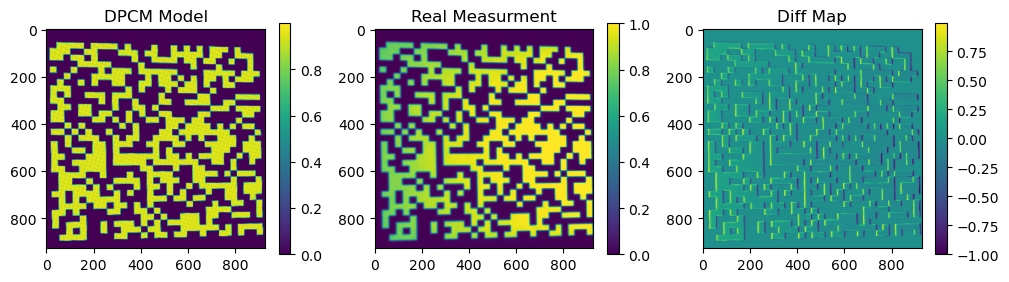

In [6]:
real_mea = cv2.cvtColor(cv2.imread('./Real_data/white/Blender_comp_bw_pattern_16_projection.png'), cv2.COLOR_BGR2GRAY)
real_mea = real_mea/real_mea.max()
plt.figure(figsize = (12,3))
plt.subplot(131)
plt.imshow(measured_img_gray)
plt.title('DPCM Model')
plt.colorbar()

plt.subplot(132)
plt.imshow(real_mea)
plt.title('Real Measurment')
plt.colorbar()

I_diff2real = measured_img_gray - real_mea
plt.subplot(133)
plt.imshow(I_diff2real)
plt.title('Diff Map')
plt.colorbar()
plt.show()